In [50]:
import yfinance as yf
import pandas as pd

# 특정 주식 데이터 다운로드 (예: 애플)
ticker = 'TSLA'
data = yf.download(ticker, start='2020-01-01', end='2024-12-01')

# 데이터 확인
print(data.head())

[*********************100%***********************]  1 of 1 completed

Price       Adj Close      Close       High        Low       Open     Volume
Ticker           TSLA       TSLA       TSLA       TSLA       TSLA       TSLA
Date                                                                        
2020-01-02  28.684000  28.684000  28.713333  28.114000  28.299999  142981500
2020-01-03  29.534000  29.534000  30.266666  29.128000  29.366667  266677500
2020-01-06  30.102667  30.102667  30.104000  29.333332  29.364668  151995000
2020-01-07  31.270666  31.270666  31.441999  30.224001  30.760000  268231500
2020-01-08  32.809334  32.809334  33.232666  31.215334  31.580000  467164500


In [52]:
# 결측치 확인
print(data.isnull().sum())

# 결측치 제거
data = data.dropna()


Price      Ticker
Adj Close  TSLA      0
Close      TSLA      0
High       TSLA      0
Low        TSLA      0
Open       TSLA      0
Volume     TSLA      0
dtype: int64


In [54]:
data['MA20'] = data['Close'].rolling(window=20).mean()
data['MA50'] = data['Close'].rolling(window=50).mean()
data['Return'] = (data['Close'] - data['Open']) / data['Open']

# 결측치 제거 (이동 평균 계산 후)
data = data.dropna()


In [56]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Volume', 'MA20', 'MA50', 'Return']])



In [58]:
import numpy as np

def create_dataset(dataset, time_steps=1):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        X.append(dataset[i:(i + time_steps), :])
        y.append(dataset[i + time_steps, 3])  # Close 가격 예측
    return np.array(X), np.array(y)

time_steps = 60  # 60일 데이터를 기반으로 예측
X, y = create_dataset(scaled_data, time_steps)

# 데이터 형태 확인
print("X shape:", X.shape)  # (samples, time_steps, features)
print("y shape:", y.shape)


X shape: (1128, 60, 8)
y shape: (1128,)


In [60]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [62]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # Close 가격 예측
])

model.compile(optimizer='adam', loss='mse')
model.summary()

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        11,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,301 (130.08 KB)

 Trainable params: 33,301 (130.08 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0952 - val_loss: 0.0082
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0109 - val_loss: 0.0035
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0081 - val_loss: 0.0032
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0062 - val_loss: 0.0031
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0071 - val_loss: 0.0019
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0058 - val_loss: 0.0022
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0054 - val_loss: 0.0018
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0057 - val_loss: 0.0021
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0049 - val_loss: 0.0019
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0047 - val_loss: 0.0020
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0046 - val_loss: 0.0023
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0

In [70]:
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.4359e-04 
Test Loss: 0.0009598355973139405


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


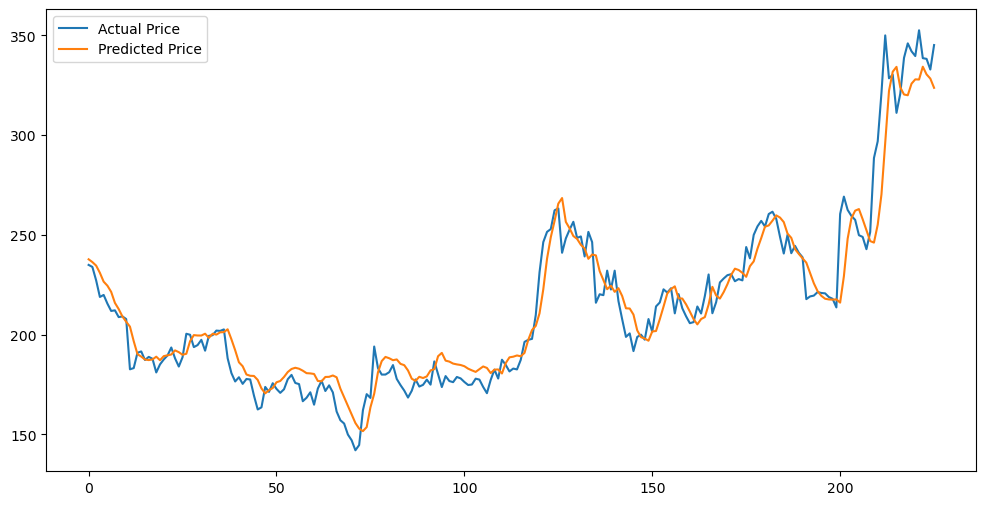

In [72]:
predictions = model.predict(X_test)

# 정규화 해제
predictions = scaler.inverse_transform([[0]*3 + [p] + [0]*4 for p in predictions.flatten()])
y_test_rescaled = scaler.inverse_transform([[0]*3 + [y] + [0]*4 for y in y_test])

# 결과 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled[:, 3], label='Actual Price')
plt.plot(predictions[:, 3], label='Predicted Price')
plt.legend()
plt.show()